In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


In [2]:
df=pd.read_csv('tesla_clean.csv')

In [3]:
df.shape

(505, 2)

In [4]:
df.head()

,Date,Close
0,2019-05-13,45.402000
1,2019-05-14,46.462002
2,2019-05-15,46.389999
3,2019-05-16,45.666000
4,2019-05-17,42.206001


In [5]:
df.set_index('Date', inplace=True)

In [6]:
#split data to train and test set
training_set = df.iloc[:450].values
test_set = df.iloc[450:].values

In [7]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 450):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])


In [8]:
#0 o dong column, de tao cac vector thanh nhung dong rieng biet
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
#save numpy to csv to do gridsearch later.
np.savetxt("Xtrain.csv", X_train, delimiter=",")
np.savetxt("ytrain.csv", y_train, delimiter=",")

Reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features]. The LSTM model is expecting a 3-dimensional data set.

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [11]:
X_train.shape

(390, 60, 1)

I will create a simple model with 4 LSTM layers and 1 output layer

In [12]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 32) #callbacks = EarlyStopping(monitor='val_loss', patience=7))

Epoch 1/200
13/13 [==============================] - 8s 105ms/step - loss: 0.0961
Epoch 2/200
13/13 [==============================] - 1s 107ms/step - loss: 0.0109
Epoch 3/200
13/13 [==============================] - 1s 106ms/step - loss: 0.0108
Epoch 4/200
13/13 [==============================] - 1s 100ms/step - loss: 0.0069
Epoch 5/200
13/13 [==============================] - 1s 92ms/step - loss: 0.0045
Epoch 6/200
13/13 [==============================] - 1s 99ms/step - loss: 0.0052
Epoch 7/200
13/13 [==============================] - 2s 122ms/step - loss: 0.0045
Epoch 8/200
13/13 [==============================] - 1s 106ms/step - loss: 0.0056
Epoch 9/200
13/13 [==============================] - 1s 94ms/step - loss: 0.0053
Epoch 10/200
13/13 [==============================] - 1s 94ms/step - loss: 0.0051
Epoch 11/200
13/13 [==============================] - 1s 94ms/step - loss: 0.0050
Epoch 12/200
13/13 [==============================] - 1s 92ms/step - loss: 0.0044
Epoch 13/200
13/13 

13/13 [==============================] - 1s 94ms/step - loss: 0.0021
Epoch 101/200
13/13 [==============================] - 1s 86ms/step - loss: 0.0027
Epoch 102/200
13/13 [==============================] - 1s 87ms/step - loss: 0.0026
Epoch 103/200
13/13 [==============================] - 1s 80ms/step - loss: 0.0023
Epoch 104/200
13/13 [==============================] - 1s 83ms/step - loss: 0.0026
Epoch 105/200
13/13 [==============================] - 1s 83ms/step - loss: 0.0022
Epoch 106/200
13/13 [==============================] - 1s 82ms/step - loss: 0.0018
Epoch 107/200
13/13 [==============================] - 1s 82ms/step - loss: 0.0025
Epoch 108/200
13/13 [==============================] - 1s 82ms/step - loss: 0.0022
Epoch 109/200
13/13 [==============================] - 1s 91ms/step - loss: 0.0025
Epoch 110/200
13/13 [==============================] - 1s 93ms/step - loss: 0.0017
Epoch 111/200
13/13 [==============================] - 1s 94ms/step - loss: 0.0028
Epoch 112/200
13/1

13/13 [==============================] - 1s 87ms/step - loss: 0.0016
Epoch 199/200
13/13 [==============================] - 1s 92ms/step - loss: 0.0014
Epoch 200/200
13/13 [==============================] - 2s 116ms/step - loss: 0.0017


# Testing our LSTM

To predict stock price on test set, I need the stock prices for the previous 60 days, so I will use my whole dataset for test data before preprocessing

In [13]:
df.head()

,Close
Date,
2019-05-13,45.402000
2019-05-14,46.462002
2019-05-15,46.389999
2019-05-16,45.666000
2019-05-17,42.206001


Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 59 test days and the 60 stock prices from the last 60 days for the training set.

In [14]:
test_inputs = df[len(df) - len(test_set) - 60:].values

As we did for the training set, we need to scale our test data

In [15]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = sc.transform(test_inputs)

In [16]:
test_inputs

array([[0.63520421],
       [0.64908366],
       [0.62765074],
       [0.64790344],
       [0.62909065],
       [0.65807697],
       [0.66475702],
       [0.71517627],
       [0.72475969],
       [0.67117744],
       [0.69783876],
       [0.67768049],
       [0.71289844],
       [0.70513254],
       [0.69276381],
       [0.73186467],
       [0.77801144],
       [0.72473606],
       [0.71350037],
       [0.72015678],
       [0.73879258],
       [0.74105859],
       [0.7437731 ],
       [0.77775182],
       [0.79060442],
       [0.81904789],
       [0.82535025],
       [0.84998154],
       [0.92086585],
       [0.9963767 ],
       [0.91514179],
       [0.9602854 ],
       [0.96615108],
       [0.9550452 ],
       [0.93280972],
       [0.95451408],
       [0.96147744],
       [0.95503338],
       [0.95698078],
       [0.99729724],
       [1.        ],
       [0.97765828],
       [0.94375043],
       [0.89429905],
       [0.94891983],
       [0.98784362],
       [0.96648158],
       [0.960

In [17]:
test_inputs.shape

(115, 1)

After scaled my data, now let's prepare our final test input set that will contain previous 60 stock prices before of the test set.

In [18]:
test_features = []
for i in range(60, 115):
    test_features.append(test_inputs[i-60:i, 0])

Reshape the data to be 3-dimensional as training set.

In [19]:
test_features = np.array(test_features)
#save test features to csv file to optimal model later
np.savetxt("test_features.csv", test_features, delimiter=",")
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

# Making Predictions

In [20]:
predictions = model.predict(test_features)

In [21]:
#inverse data from scale 0-1 to the original scale.
predictions = sc.inverse_transform(predictions)

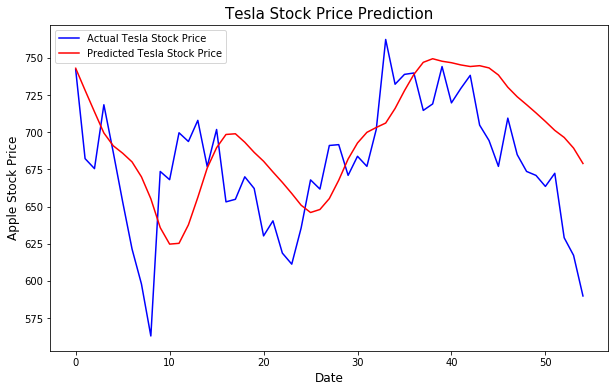

In [22]:
plt.figure(figsize=(10,6))
plt.plot(test_set, color='blue', label='Actual Tesla Stock Price')
plt.plot(predictions , color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Apple Stock Price', fontsize=12)
plt.legend()
plt.show()

In [23]:
print('The RMSE of LSTM :', mean_squared_error(test_set, predictions)**0.5)

The RMSE of LSTM : 41.35647359729378


Compare to Auto Arima model, my neural network performed better from 87.33 decrease to 41.35. It is a good sign, next I will optimize my neural network model , and see how it improve.